### PUC Minas - Pontifícia Universidade Católica de Minas Gerais
**Pós-Graduação em Ciência de Dados e Big Data**<br>
**TCC - Trabalho de Conclusão de Curso**

# Avaliação da efetividade da gestão de riscos na importação

**Aluno: Carlos Frederico Schwochow de Miranda**

In [1]:
# Importando as bibliotecas e setando variáveis de ambiente

# !pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

%matplotlib inline
pd.options.display.max_rows = 200

In [2]:
# Carregando o dataset
file = 'dataset.csv'
df_diSelecionadas = pd.read_csv(file, encoding = 'ISO-8859-1', sep = ';')
df_diSelecionadas.head()

,nroDI,importador,adquirente,impPropria,tipoDI,rfDespacho,ufDespacho,paisProcedencia,viaTransporte,retificacao,qtdAdicoes,qtdItens,valorCIF,valorTributos
0,2124290818,"3,35E+13","3,35E+13",True,CONSUMO,8ª RF,SP,ITALIA,AEREA,0,1,1,55.93,25.23
1,2123103453,"2,38E+13","2,38E+13",True,CONSUMO,7ª RF,RJ,PAIS_OUTROS,ENTRADA/SAIDA FICTA,0,1,1,67.39,7.91
2,2100959653,"4,30E+12","4,30E+12",True,CONSUMO,8ª RF,SP,ESPANHA,AEREA,0,1,1,158.51,21.78
3,2103371983,"5,93E+13","5,93E+13",True,CONSUMO,8ª RF,SP,PAIS_OUTROS,AEREA,0,1,3,275.47,32.36
4,2124290826,"3,35E+13","3,35E+13",True,CONSUMO,8ª RF,SP,ITALIA,AEREA,1,1,1,287.69,129.88


In [3]:
df_diSelecionadas.dtypes

nroDI                int64
importador          object
adquirente          object
impPropria            bool
tipoDI              object
rfDespacho          object
ufDespacho          object
paisProcedencia     object
viaTransporte       object
retificacao          int64
qtdAdicoes           int64
qtdItens             int64
valorCIF           float64
valorTributos      float64
dtype: object

In [4]:
# Removendo as colunas nroDI, importador e adquirente, utilizadas somente para o enriquecimento dos dados

# O enriquecimento dos dados foi realizado através da ferramenta Contágil, com o uso da linguagem SQL em diversas
# consultas às bases de dados da RFB.

df_diSelecionadas.drop(['nroDI'], axis = 1, inplace = True)
df_diSelecionadas.drop(['importador'], axis = 1, inplace = True)
df_diSelecionadas.drop(['adquirente'], axis = 1, inplace = True)
df_diSelecionadas.head()

,impPropria,tipoDI,rfDespacho,ufDespacho,paisProcedencia,viaTransporte,retificacao,qtdAdicoes,qtdItens,valorCIF,valorTributos
0,True,CONSUMO,8ª RF,SP,ITALIA,AEREA,0,1,1,55.93,25.23
1,True,CONSUMO,7ª RF,RJ,PAIS_OUTROS,ENTRADA/SAIDA FICTA,0,1,1,67.39,7.91
2,True,CONSUMO,8ª RF,SP,ESPANHA,AEREA,0,1,1,158.51,21.78
3,True,CONSUMO,8ª RF,SP,PAIS_OUTROS,AEREA,0,1,3,275.47,32.36
4,True,CONSUMO,8ª RF,SP,ITALIA,AEREA,1,1,1,287.69,129.88


In [5]:
df_diSelecionadas.shape

(14338, 11)

In [6]:
indexNames = df_diSelecionadas[(df_diSelecionadas['rfDespacho'] != '10ª RF')].index

In [7]:
print(indexNames)

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            14326, 14329, 14330, 14331, 14332, 14333, 14334, 14335, 14336,
            14337],
           dtype='int64', length=12679)


In [8]:
df_diSelecionadas.drop(indexNames, inplace=True)
df_diSelecionadas.shape

(1659, 11)

In [9]:
# Verificando os tipos das variáveis do dataframe
df_diSelecionadas.dtypes

impPropria            bool
tipoDI              object
rfDespacho          object
ufDespacho          object
paisProcedencia     object
viaTransporte       object
retificacao          int64
qtdAdicoes           int64
qtdItens             int64
valorCIF           float64
valorTributos      float64
dtype: object

In [10]:
# Verificando missing values
df_diSelecionadas.isnull().sum()

impPropria         0
tipoDI             0
rfDespacho         0
ufDespacho         0
paisProcedencia    0
viaTransporte      0
retificacao        0
qtdAdicoes         0
qtdItens           0
valorCIF           0
valorTributos      0
dtype: int64

## Tratamento das variáveis categóricas

In [11]:
# Verificando os valores existentes para a coluna impPropria (cardinalidade)
df_diSelecionadas['impPropria'].unique()

array([ True, False])

In [12]:
# Verificando o número de registros para cada valor da coluna impPropria
df_diSelecionadas['impPropria'].value_counts()

True     1615
False      44
Name: impPropria, dtype: int64

In [13]:
# Criando uma nova coluna [le_impPropria], com base na variável impPropria (Label Encoder)
le = LabelEncoder()
df_diSelecionadas['le_impPropria'] = le.fit_transform(df_diSelecionadas['impPropria'])
df_diSelecionadas.head()

,impPropria,tipoDI,rfDespacho,ufDespacho,paisProcedencia,viaTransporte,retificacao,qtdAdicoes,qtdItens,valorCIF,valorTributos,le_impPropria
10,True,CONSUMO,10ª RF,RS,PAIS_OUTROS,AEREA,0,1,1,795.59,173.02,1
35,True,ADMISSAO EM LOJA FRANCA,10ª RF,RS,PAIS_OUTROS,RODOVIARIA,0,1,1,1348.08,0.00,1
72,True,CONSUMO,10ª RF,RS,ITALIA,AEREA,1,2,2,1946.70,809.85,1
81,True,CONSUMO,10ª RF,RS,INDIA,AEREA,1,4,4,2192.18,859.10,1
95,True,NACIONALIZACAO DE ENTREPOSTO ADUANEIRO,10ª RF,RS,"CHINA, REPUBLICA POPULAR",MARITIMA,1,1,1,2556.43,1154.21,1


In [14]:
# Conferindo a variável label encoder criada
df_diSelecionadas['le_impPropria'].value_counts()

1    1615
0      44
Name: le_impPropria, dtype: int64

In [15]:
# Verificando os valores existentes para a coluna tipoDI (cardinalidade)
df_diSelecionadas['tipoDI'].unique()

array(['CONSUMO', 'ADMISSAO EM LOJA FRANCA',
       'NACIONALIZACAO DE ENTREPOSTO ADUANEIRO', 'ADMISSAO TEMPORARIA',
       'NACIONALIZACAO DE ADMISSAO TEMPORARIA',
       'ADMISSAO EM ENTREPOSTO ADUANEIRO',
       'CONSUMO E ADMISSAO TEMPORARIA'], dtype=object)

In [16]:
# Verificando o número de registros para cada valor da coluna tipoDI
df_diSelecionadas['tipoDI'].value_counts()

CONSUMO                                   1526
ADMISSAO TEMPORARIA                         34
ADMISSAO EM LOJA FRANCA                     32
NACIONALIZACAO DE ENTREPOSTO ADUANEIRO      27
ADMISSAO EM ENTREPOSTO ADUANEIRO            20
NACIONALIZACAO DE ADMISSAO TEMPORARIA       15
CONSUMO E ADMISSAO TEMPORARIA                5
Name: tipoDI, dtype: int64

In [17]:
# Agrupando os valores da coluna tipoDI
df_diSelecionadas['tipoDI'] = df_diSelecionadas['tipoDI'].replace({'NACIONALIZACAO DE ENTREPOSTO ADUANEIRO':'REGIMES_OUTROS',
                                                                   'ADMISSAO EM ENTREPOSTO ADUANEIRO':'REGIMES_OUTROS',
                                                                   'ADMISSAO TEMPORARIA':'REGIMES_OUTROS',
                                                                   'NACIONALIZACAO DE ADMISSAO TEMPORARIA':'REGIMES_OUTROS',
                                                                   'ADMISSAO EM LOJA FRANCA':'REGIMES_OUTROS',
                                                                   'CONSUMO E ADMISSAO TEMPORARIA':'REGIMES_OUTROS'})
df_diSelecionadas['tipoDI'].value_counts()

CONSUMO           1526
REGIMES_OUTROS     133
Name: tipoDI, dtype: int64

In [18]:
# Criando variáveis dummies para a coluna tipoDI
dummies = pd.get_dummies(df_diSelecionadas['tipoDI'], prefix = 'dm') # drop_first = True
df_diSelecionadas = pd.concat([df_diSelecionadas, dummies], axis = 1)
df_diSelecionadas.head()

,impPropria,tipoDI,rfDespacho,ufDespacho,paisProcedencia,viaTransporte,retificacao,qtdAdicoes,qtdItens,valorCIF,valorTributos,le_impPropria,dm_CONSUMO,dm_REGIMES_OUTROS
10,True,CONSUMO,10ª RF,RS,PAIS_OUTROS,AEREA,0,1,1,795.59,173.02,1,1,0
35,True,REGIMES_OUTROS,10ª RF,RS,PAIS_OUTROS,RODOVIARIA,0,1,1,1348.08,0.00,1,0,1
72,True,CONSUMO,10ª RF,RS,ITALIA,AEREA,1,2,2,1946.70,809.85,1,1,0
81,True,CONSUMO,10ª RF,RS,INDIA,AEREA,1,4,4,2192.18,859.10,1,1,0
95,True,REGIMES_OUTROS,10ª RF,RS,"CHINA, REPUBLICA POPULAR",MARITIMA,1,1,1,2556.43,1154.21,1,0,1


In [19]:
df_diSelecionadas.shape

(1659, 14)

In [20]:
# Verificando os valores existentes para a coluna paisProcedencia (cardinalidade)
df_diSelecionadas['paisProcedencia'].unique()

array(['PAIS_OUTROS', 'ITALIA', 'INDIA', 'CHINA, REPUBLICA POPULAR',
       'ESPANHA', 'ESTADOS UNIDOS', 'HONG KONG', 'ALEMANHA', 'ARGENTINA',
       'PAISES BAIXOS (HOLANDA)'], dtype=object)

In [21]:
# Verificando o número de registros para cada valor da coluna paisProcedencia

# Tendo em vista a alta cardinalidade verificada nos dados originais, contendo 103 valores distintos, procedeu-se
# o agrupamento dos dados, considerados os 9 países com maior volume de declarações de importação selecionadas, sendo
# criada a classe PAIS_OUTROS para as entradas restantes da base de dados. Esse agrupamento foi realizado com o uso da
# ferramenta Contágil, por questões de simplificação.

df_diSelecionadas["paisProcedencia"].value_counts()

CHINA, REPUBLICA POPULAR    497
PAIS_OUTROS                 382
ARGENTINA                   210
ITALIA                      173
ESTADOS UNIDOS              170
ALEMANHA                    119
INDIA                        34
ESPANHA                      33
HONG KONG                    28
PAISES BAIXOS (HOLANDA)      13
Name: paisProcedencia, dtype: int64

In [22]:
# Organizando os valores da coluna paisProcedencia
df_diSelecionadas['paisProcedencia'] = df_diSelecionadas['paisProcedencia'].replace({'CHINA, REPUBLICA POPULAR':'CHINA',
                                                                                     'ESTADOS UNIDOS':'EUA',
                                                                                     'INDIA':'PAIS_OUTROS',
                                                                                     'ESPANHA':'PAIS_OUTROS',
                                                                                     'HONG KONG':'PAIS_OUTROS',
                                                                                     'PAISES BAIXOS (HOLANDA)':'PAIS_OUTROS'})
df_diSelecionadas['paisProcedencia'].value_counts()

CHINA          497
PAIS_OUTROS    490
ARGENTINA      210
ITALIA         173
EUA            170
ALEMANHA       119
Name: paisProcedencia, dtype: int64

In [23]:
# Criando variáveis dummies para a coluna paisProcedencia
dummies = pd.get_dummies(df_diSelecionadas['paisProcedencia'], prefix = 'dm') # drop_first = True
df_diSelecionadas = pd.concat([df_diSelecionadas, dummies], axis = 1)
df_diSelecionadas.head()

,impPropria,tipoDI,rfDespacho,ufDespacho,paisProcedencia,viaTransporte,retificacao,qtdAdicoes,qtdItens,valorCIF,valorTributos,le_impPropria,dm_CONSUMO,dm_REGIMES_OUTROS,dm_ALEMANHA,dm_ARGENTINA,dm_CHINA,dm_EUA,dm_ITALIA,dm_PAIS_OUTROS
10,True,CONSUMO,10ª RF,RS,PAIS_OUTROS,AEREA,0,1,1,795.59,173.02,1,1,0,0,0,0,0,0,1
35,True,REGIMES_OUTROS,10ª RF,RS,PAIS_OUTROS,RODOVIARIA,0,1,1,1348.08,0.00,1,0,1,0,0,0,0,0,1
72,True,CONSUMO,10ª RF,RS,ITALIA,AEREA,1,2,2,1946.70,809.85,1,1,0,0,0,0,0,1,0
81,True,CONSUMO,10ª RF,RS,PAIS_OUTROS,AEREA,1,4,4,2192.18,859.10,1,1,0,0,0,0,0,0,1
95,True,REGIMES_OUTROS,10ª RF,RS,CHINA,MARITIMA,1,1,1,2556.43,1154.21,1,0,1,0,0,1,0,0,0


In [24]:
# Verificando os valores existentes para a coluna viaTransporte (cardinalidade)
df_diSelecionadas['viaTransporte'].unique()

array(['AEREA', 'RODOVIARIA', 'MARITIMA', 'MEIOS PROPRIOS',
       'CONDUTO / REDE TRANSMISSAO'], dtype=object)

In [25]:
# Verificando o número de registros para cada valor da coluna viaTransporte
df_diSelecionadas['viaTransporte'].value_counts()

MARITIMA                      981
RODOVIARIA                    356
AEREA                         319
MEIOS PROPRIOS                  2
CONDUTO / REDE TRANSMISSAO      1
Name: viaTransporte, dtype: int64

In [26]:
# Agrupando os valores da coluna viaTransporte
df_diSelecionadas['viaTransporte'] = df_diSelecionadas['viaTransporte'].replace({'MEIOS PROPRIOS':'RODOVIARIA',
                                                                                 'CONDUTO / REDE TRANSMISSAO':'RODOVIARIA'})
df_diSelecionadas['viaTransporte'].value_counts()

MARITIMA      981
RODOVIARIA    359
AEREA         319
Name: viaTransporte, dtype: int64

In [27]:
# Criando variáveis dummies para a coluna viaTransporte
dummies = pd.get_dummies(df_diSelecionadas['viaTransporte'], prefix = 'dm') # drop_first = True
df_diSelecionadas = pd.concat([df_diSelecionadas, dummies], axis = 1)
df_diSelecionadas.head()

,impPropria,tipoDI,rfDespacho,ufDespacho,paisProcedencia,viaTransporte,retificacao,qtdAdicoes,qtdItens,valorCIF,...,dm_REGIMES_OUTROS,dm_ALEMANHA,dm_ARGENTINA,dm_CHINA,dm_EUA,dm_ITALIA,dm_PAIS_OUTROS,dm_AEREA,dm_MARITIMA,dm_RODOVIARIA
10,True,CONSUMO,10ª RF,RS,PAIS_OUTROS,AEREA,0,1,1,795.59,...,0,0,0,0,0,0,1,1,0,0
35,True,REGIMES_OUTROS,10ª RF,RS,PAIS_OUTROS,RODOVIARIA,0,1,1,1348.08,...,1,0,0,0,0,0,1,0,0,1
72,True,CONSUMO,10ª RF,RS,ITALIA,AEREA,1,2,2,1946.70,...,0,0,0,0,0,1,0,1,0,0
81,True,CONSUMO,10ª RF,RS,PAIS_OUTROS,AEREA,1,4,4,2192.18,...,0,0,0,0,0,0,1,1,0,0
95,True,REGIMES_OUTROS,10ª RF,RS,CHINA,MARITIMA,1,1,1,2556.43,...,1,0,0,1,0,0,0,0,1,0


In [28]:
df_diSelecionadas.dtypes

impPropria              bool
tipoDI                object
rfDespacho            object
ufDespacho            object
paisProcedencia       object
viaTransporte         object
retificacao            int64
qtdAdicoes             int64
qtdItens               int64
valorCIF             float64
valorTributos        float64
le_impPropria          int64
dm_CONSUMO             uint8
dm_REGIMES_OUTROS      uint8
dm_ALEMANHA            uint8
dm_ARGENTINA           uint8
dm_CHINA               uint8
dm_EUA                 uint8
dm_ITALIA              uint8
dm_PAIS_OUTROS         uint8
dm_AEREA               uint8
dm_MARITIMA            uint8
dm_RODOVIARIA          uint8
dtype: object

## Tratamento das variáveis quantitativas

In [29]:
# Verificando a distribuição da variável qtdAdicoes
df_diSelecionadas['qtdAdicoes'].describe()

count    1659.000000
mean        3.904159
std         8.690627
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       133.000000
Name: qtdAdicoes, dtype: float64

In [30]:
# Transformando a variável qtdAdicoes em categórica

# Conforme a distribuição da variável e as regras de negócio, optou-se pelas seguintes categorias:

#    1 - Declarações com 1 adição
#    2 - Declarações com 2 até 9 adições
#    3 - Declarações com 10 ou mais adições

def transf_qtdAdicoes(x):
    if x > 9:
        x = 3
    elif x > 1:
        x = 2
    else:
        x = 1
    return x

df_diSelecionadas['cat_qtdAdicoes'] = df_diSelecionadas['qtdAdicoes'].apply(lambda x: str(transf_qtdAdicoes(x)))
df_diSelecionadas['cat_qtdAdicoes'].unique()

array(['1', '2', '3'], dtype=object)

In [31]:
# Criando variáveis dummies para a coluna cat_qtdAdicoes
dummies = pd.get_dummies(df_diSelecionadas['cat_qtdAdicoes'], prefix = 'dm_qtdAdicoes') # drop_first = True
df_diSelecionadas = pd.concat([df_diSelecionadas, dummies], axis = 1)
df_diSelecionadas.head()

,impPropria,tipoDI,rfDespacho,ufDespacho,paisProcedencia,viaTransporte,retificacao,qtdAdicoes,qtdItens,valorCIF,...,dm_EUA,dm_ITALIA,dm_PAIS_OUTROS,dm_AEREA,dm_MARITIMA,dm_RODOVIARIA,cat_qtdAdicoes,dm_qtdAdicoes_1,dm_qtdAdicoes_2,dm_qtdAdicoes_3
10,True,CONSUMO,10ª RF,RS,PAIS_OUTROS,AEREA,0,1,1,795.59,...,0,0,1,1,0,0,1,1,0,0
35,True,REGIMES_OUTROS,10ª RF,RS,PAIS_OUTROS,RODOVIARIA,0,1,1,1348.08,...,0,0,1,0,0,1,1,1,0,0
72,True,CONSUMO,10ª RF,RS,ITALIA,AEREA,1,2,2,1946.70,...,0,1,0,1,0,0,2,0,1,0
81,True,CONSUMO,10ª RF,RS,PAIS_OUTROS,AEREA,1,4,4,2192.18,...,0,0,1,1,0,0,2,0,1,0
95,True,REGIMES_OUTROS,10ª RF,RS,CHINA,MARITIMA,1,1,1,2556.43,...,0,0,0,0,1,0,1,1,0,0


In [32]:
df_diSelecionadas['cat_qtdAdicoes'].value_counts()

1    911
2    611
3    137
Name: cat_qtdAdicoes, dtype: int64

In [33]:
df_diSelecionadas['dm_qtdAdicoes_1'].value_counts()

1    911
0    748
Name: dm_qtdAdicoes_1, dtype: int64

In [34]:
df_diSelecionadas['dm_qtdAdicoes_2'].value_counts()

0    1048
1     611
Name: dm_qtdAdicoes_2, dtype: int64

In [35]:
df_diSelecionadas['dm_qtdAdicoes_3'].value_counts()

0    1522
1     137
Name: dm_qtdAdicoes_3, dtype: int64

In [36]:
# Verificando a distribuição da variável qtdItens
df_diSelecionadas['qtdItens'].describe()

count    1659.000000
mean       13.208559
std        35.850328
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       648.000000
Name: qtdItens, dtype: float64

In [37]:
# Transformando a variável qtdItens em categórica

# Conforme a distribuição da variável e as regras de negócio, optou-se pelas seguintes categorias:

#    1 - Declarações com até 3 itens
#    2 - Declarações com 4 até 15 itens
#    3 - Declarações com 16 ou mais itens

def transf_qtdItens(x):
    if x > 15:
        x = 3
    elif x > 3:
        x = 2
    else:
        x = 1
    return x

df_diSelecionadas['cat_qtdItens'] = df_diSelecionadas['qtdItens'].apply(lambda x: str(transf_qtdItens(x)))
df_diSelecionadas['cat_qtdItens'].unique()

array(['1', '2', '3'], dtype=object)

In [38]:
# Criando variáveis dummies para a coluna cat_qtdItens
dummies = pd.get_dummies(df_diSelecionadas['cat_qtdItens'], prefix = 'dm_qtdItens') # drop_first = True
df_diSelecionadas = pd.concat([df_diSelecionadas, dummies], axis = 1)
df_diSelecionadas.head()

,impPropria,tipoDI,rfDespacho,ufDespacho,paisProcedencia,viaTransporte,retificacao,qtdAdicoes,qtdItens,valorCIF,...,dm_MARITIMA,dm_RODOVIARIA,cat_qtdAdicoes,dm_qtdAdicoes_1,dm_qtdAdicoes_2,dm_qtdAdicoes_3,cat_qtdItens,dm_qtdItens_1,dm_qtdItens_2,dm_qtdItens_3
10,True,CONSUMO,10ª RF,RS,PAIS_OUTROS,AEREA,0,1,1,795.59,...,0,0,1,1,0,0,1,1,0,0
35,True,REGIMES_OUTROS,10ª RF,RS,PAIS_OUTROS,RODOVIARIA,0,1,1,1348.08,...,0,1,1,1,0,0,1,1,0,0
72,True,CONSUMO,10ª RF,RS,ITALIA,AEREA,1,2,2,1946.70,...,0,0,2,0,1,0,1,1,0,0
81,True,CONSUMO,10ª RF,RS,PAIS_OUTROS,AEREA,1,4,4,2192.18,...,0,0,2,0,1,0,2,0,1,0
95,True,REGIMES_OUTROS,10ª RF,RS,CHINA,MARITIMA,1,1,1,2556.43,...,1,0,1,1,0,0,1,1,0,0


In [39]:
df_diSelecionadas['cat_qtdItens'].value_counts()

1    924
2    445
3    290
Name: cat_qtdItens, dtype: int64

In [40]:
df_diSelecionadas['dm_qtdItens_1'].value_counts()

1    924
0    735
Name: dm_qtdItens_1, dtype: int64

In [41]:
df_diSelecionadas['dm_qtdItens_2'].value_counts()

0    1214
1     445
Name: dm_qtdItens_2, dtype: int64

In [42]:
df_diSelecionadas['dm_qtdItens_3'].value_counts()

0    1369
1     290
Name: dm_qtdItens_3, dtype: int64

In [43]:
# Verificando a distribuição da variável valorCIF
df_diSelecionadas['valorCIF'].describe()

count    1.659000e+03
mean     6.046641e+05
std      1.896570e+06
min      7.955900e+02
25%      9.216380e+04
50%      2.034394e+05
75%      5.027874e+05
max      4.347081e+07
Name: valorCIF, dtype: float64

In [44]:
# Transformando a variável valorCIF em categórica

# Conforme a distribuição da variável e as regras de negócio, optou-se pelas seguintes categorias:

#    1 - Valor CIF até R$ 75.000,00
#    2 - Valor CIF entre R$ 75.000,01 e R$ 185.000,00
#    3 - Valor CIF entre R$ 185.000,01 e R$ 370.000,00
#    4 - Valor CIF acima de R$ 370.000,01

def transf_valorCIF(x):
    if x > 370000:
        x = 4
    elif x > 185000:
        x = 3
    elif x > 75000:
        x = 2
    else:
        x = 1
    return x

df_diSelecionadas['cat_valorCIF'] = df_diSelecionadas['valorCIF'].apply(lambda x: str(transf_valorCIF(x)))
df_diSelecionadas['cat_valorCIF'].unique()

array(['1', '2', '3', '4'], dtype=object)

In [45]:
# Criando variáveis dummies para a coluna valorCIF
dummies = pd.get_dummies(df_diSelecionadas['cat_valorCIF'], prefix = 'dm_valorCIF') # drop_first = True
df_diSelecionadas = pd.concat([df_diSelecionadas, dummies], axis = 1)
df_diSelecionadas.head()

,impPropria,tipoDI,rfDespacho,ufDespacho,paisProcedencia,viaTransporte,retificacao,qtdAdicoes,qtdItens,valorCIF,...,dm_qtdAdicoes_3,cat_qtdItens,dm_qtdItens_1,dm_qtdItens_2,dm_qtdItens_3,cat_valorCIF,dm_valorCIF_1,dm_valorCIF_2,dm_valorCIF_3,dm_valorCIF_4
10,True,CONSUMO,10ª RF,RS,PAIS_OUTROS,AEREA,0,1,1,795.59,...,0,1,1,0,0,1,1,0,0,0
35,True,REGIMES_OUTROS,10ª RF,RS,PAIS_OUTROS,RODOVIARIA,0,1,1,1348.08,...,0,1,1,0,0,1,1,0,0,0
72,True,CONSUMO,10ª RF,RS,ITALIA,AEREA,1,2,2,1946.70,...,0,1,1,0,0,1,1,0,0,0
81,True,CONSUMO,10ª RF,RS,PAIS_OUTROS,AEREA,1,4,4,2192.18,...,0,2,0,1,0,1,1,0,0,0
95,True,REGIMES_OUTROS,10ª RF,RS,CHINA,MARITIMA,1,1,1,2556.43,...,0,1,1,0,0,1,1,0,0,0


In [46]:
df_diSelecionadas['cat_valorCIF'].value_counts()

4    538
2    420
3    351
1    350
Name: cat_valorCIF, dtype: int64

In [47]:
df_diSelecionadas['dm_valorCIF_1'].value_counts()

0    1309
1     350
Name: dm_valorCIF_1, dtype: int64

In [48]:
df_diSelecionadas['dm_valorCIF_2'].value_counts()

0    1239
1     420
Name: dm_valorCIF_2, dtype: int64

In [49]:
df_diSelecionadas['dm_valorCIF_3'].value_counts()

0    1308
1     351
Name: dm_valorCIF_3, dtype: int64

In [50]:
df_diSelecionadas['dm_valorCIF_4'].value_counts()

0    1121
1     538
Name: dm_valorCIF_4, dtype: int64

In [51]:
# Verificando a distribuição da variável valorTributos
df_diSelecionadas['valorTributos'].describe()

count    1.659000e+03
mean     9.538453e+04
std      2.417594e+05
min      0.000000e+00
25%      1.126838e+04
50%      3.766314e+04
75%      9.498598e+04
max      5.107820e+06
Name: valorTributos, dtype: float64

In [52]:
# Transformando a variável valorTributos em categórica

# Conforme a distribuição da variável e as regras de negócio, optou-se pelas seguintes categorias:

#    1 - Valor de tributos recolhidos até R$ 15.000,00
#    2 - Valor de tributos recolhidos entre R$ 15.000,01 e R$ 50.000,00
#    3 - Valor de tributos recolhidos entre R$ 50.000,01 e R$ 100.000,00
#    4 - Valor de tributos recolhidos acima de R$ 100.000,01

def transf_valorTributos(x):
    if x > 100000:
        x = 4
    elif x > 50000:
        x = 3
    elif x > 15000:
        x = 2
    else:
        x = 1
    return x

df_diSelecionadas['cat_valorTributos'] = df_diSelecionadas['valorTributos'].apply(lambda x: str(transf_valorTributos(x)))
df_diSelecionadas['cat_valorTributos'].unique()

array(['1', '2', '3', '4'], dtype=object)

In [53]:
# Criando variáveis dummies para a coluna valorTributos
dummies = pd.get_dummies(df_diSelecionadas['cat_valorTributos'], prefix = 'dm_valorTributos') # drop_first = True
df_diSelecionadas = pd.concat([df_diSelecionadas, dummies], axis = 1)
df_diSelecionadas.head()

,impPropria,tipoDI,rfDespacho,ufDespacho,paisProcedencia,viaTransporte,retificacao,qtdAdicoes,qtdItens,valorCIF,...,cat_valorCIF,dm_valorCIF_1,dm_valorCIF_2,dm_valorCIF_3,dm_valorCIF_4,cat_valorTributos,dm_valorTributos_1,dm_valorTributos_2,dm_valorTributos_3,dm_valorTributos_4
10,True,CONSUMO,10ª RF,RS,PAIS_OUTROS,AEREA,0,1,1,795.59,...,1,1,0,0,0,1,1,0,0,0
35,True,REGIMES_OUTROS,10ª RF,RS,PAIS_OUTROS,RODOVIARIA,0,1,1,1348.08,...,1,1,0,0,0,1,1,0,0,0
72,True,CONSUMO,10ª RF,RS,ITALIA,AEREA,1,2,2,1946.70,...,1,1,0,0,0,1,1,0,0,0
81,True,CONSUMO,10ª RF,RS,PAIS_OUTROS,AEREA,1,4,4,2192.18,...,1,1,0,0,0,1,1,0,0,0
95,True,REGIMES_OUTROS,10ª RF,RS,CHINA,MARITIMA,1,1,1,2556.43,...,1,1,0,0,0,1,1,0,0,0


In [54]:
df_diSelecionadas['cat_valorTributos'].value_counts()

2    489
1    487
4    394
3    289
Name: cat_valorTributos, dtype: int64

In [55]:
df_diSelecionadas['dm_valorTributos_1'].value_counts()

0    1172
1     487
Name: dm_valorTributos_1, dtype: int64

In [56]:
df_diSelecionadas['dm_valorTributos_2'].value_counts()

0    1170
1     489
Name: dm_valorTributos_2, dtype: int64

In [57]:
df_diSelecionadas['dm_valorTributos_3'].value_counts()

0    1370
1     289
Name: dm_valorTributos_3, dtype: int64

In [58]:
df_diSelecionadas['dm_valorTributos_4'].value_counts()

0    1265
1     394
Name: dm_valorTributos_4, dtype: int64

In [59]:
# Removendo as variáveis originais não categóricas e criando o dataframe df_catDI
df_diSelecionadas.columns

Index(['impPropria', 'tipoDI', 'rfDespacho', 'ufDespacho', 'paisProcedencia',
       'viaTransporte', 'retificacao', 'qtdAdicoes', 'qtdItens', 'valorCIF',
       'valorTributos', 'le_impPropria', 'dm_CONSUMO', 'dm_REGIMES_OUTROS',
       'dm_ALEMANHA', 'dm_ARGENTINA', 'dm_CHINA', 'dm_EUA', 'dm_ITALIA',
       'dm_PAIS_OUTROS', 'dm_AEREA', 'dm_MARITIMA', 'dm_RODOVIARIA',
       'cat_qtdAdicoes', 'dm_qtdAdicoes_1', 'dm_qtdAdicoes_2',
       'dm_qtdAdicoes_3', 'cat_qtdItens', 'dm_qtdItens_1', 'dm_qtdItens_2',
       'dm_qtdItens_3', 'cat_valorCIF', 'dm_valorCIF_1', 'dm_valorCIF_2',
       'dm_valorCIF_3', 'dm_valorCIF_4', 'cat_valorTributos',
       'dm_valorTributos_1', 'dm_valorTributos_2', 'dm_valorTributos_3',
       'dm_valorTributos_4'],
      dtype='object')

In [60]:
df_catDI = df_diSelecionadas.drop(columns=['impPropria', 'tipoDI', 'rfDespacho', 'ufDespacho', 'paisProcedencia',
                                           'viaTransporte','qtdAdicoes', 'qtdItens', 'valorCIF', 'valorTributos',
                                           'cat_qtdAdicoes', 'cat_qtdItens', 'cat_valorCIF', 'cat_valorTributos'])
df_catDI.columns

Index(['retificacao', 'le_impPropria', 'dm_CONSUMO', 'dm_REGIMES_OUTROS',
       'dm_ALEMANHA', 'dm_ARGENTINA', 'dm_CHINA', 'dm_EUA', 'dm_ITALIA',
       'dm_PAIS_OUTROS', 'dm_AEREA', 'dm_MARITIMA', 'dm_RODOVIARIA',
       'dm_qtdAdicoes_1', 'dm_qtdAdicoes_2', 'dm_qtdAdicoes_3',
       'dm_qtdItens_1', 'dm_qtdItens_2', 'dm_qtdItens_3', 'dm_valorCIF_1',
       'dm_valorCIF_2', 'dm_valorCIF_3', 'dm_valorCIF_4', 'dm_valorTributos_1',
       'dm_valorTributos_2', 'dm_valorTributos_3', 'dm_valorTributos_4'],
      dtype='object')

In [61]:
df_catDI.head()

,retificacao,le_impPropria,dm_CONSUMO,dm_REGIMES_OUTROS,dm_ALEMANHA,dm_ARGENTINA,dm_CHINA,dm_EUA,dm_ITALIA,dm_PAIS_OUTROS,...,dm_qtdItens_2,dm_qtdItens_3,dm_valorCIF_1,dm_valorCIF_2,dm_valorCIF_3,dm_valorCIF_4,dm_valorTributos_1,dm_valorTributos_2,dm_valorTributos_3,dm_valorTributos_4
10,0,1,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
35,0,1,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
72,1,1,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
81,1,1,1,0,0,0,0,0,0,1,...,1,0,1,0,0,0,1,0,0,0
95,1,1,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0


## Analisando e explorando os dados (Feature Engineering)

In [62]:
# Após as transformações realizadas, todas as variáveis tornaram-se categóricas.
df_catDI.dtypes

retificacao           int64
le_impPropria         int64
dm_CONSUMO            uint8
dm_REGIMES_OUTROS     uint8
dm_ALEMANHA           uint8
dm_ARGENTINA          uint8
dm_CHINA              uint8
dm_EUA                uint8
dm_ITALIA             uint8
dm_PAIS_OUTROS        uint8
dm_AEREA              uint8
dm_MARITIMA           uint8
dm_RODOVIARIA         uint8
dm_qtdAdicoes_1       uint8
dm_qtdAdicoes_2       uint8
dm_qtdAdicoes_3       uint8
dm_qtdItens_1         uint8
dm_qtdItens_2         uint8
dm_qtdItens_3         uint8
dm_valorCIF_1         uint8
dm_valorCIF_2         uint8
dm_valorCIF_3         uint8
dm_valorCIF_4         uint8
dm_valorTributos_1    uint8
dm_valorTributos_2    uint8
dm_valorTributos_3    uint8
dm_valorTributos_4    uint8
dtype: object

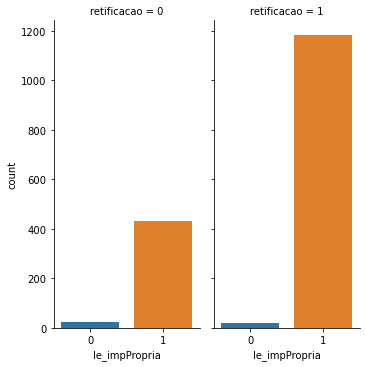

In [63]:
# Plotando a variável le_impPropria
sns.catplot(data=df_catDI, x='le_impPropria', col='retificacao', kind="count", height=5, aspect=0.5);

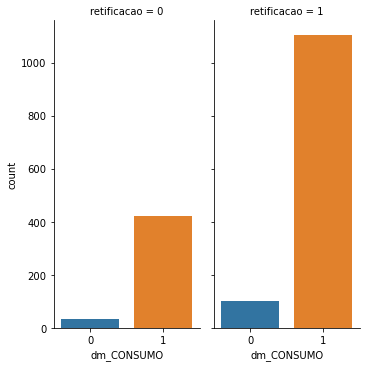

In [64]:
# Plotando a variável dm_CONSUMO
sns.catplot(data=df_catDI, x='dm_CONSUMO', col='retificacao', kind="count", height=5, aspect=0.5);

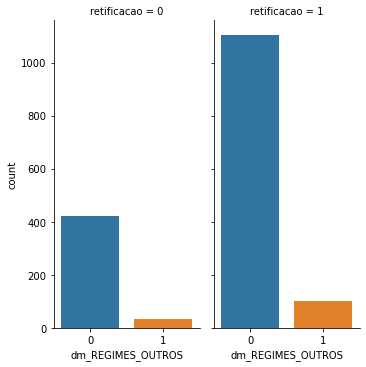

In [65]:
# Plotando a variável dm_REGIMES_OUTROS
sns.catplot(data=df_catDI, x='dm_REGIMES_OUTROS', col='retificacao', kind="count", height=5, aspect=0.5);

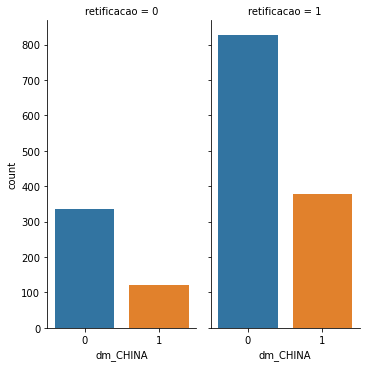

In [66]:
# Plotando a variável dm_CHINA
sns.catplot(data=df_catDI, x='dm_CHINA', col='retificacao', kind="count", height=5, aspect=0.5);
# dm_ALEMANHA, dm_ARGENTINA, dm_ESPANHA, dm_EUA, dm_HOLANDA, dm_HONG_KONG, dm_INDIA, dm_ITALIA, dm_PAIS_OUTROS

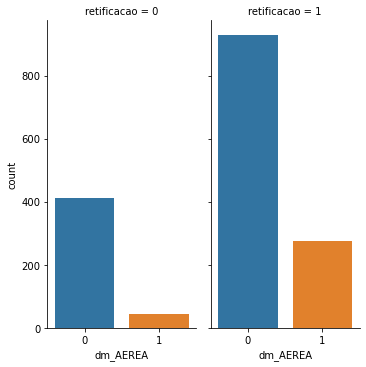

In [67]:
# Plotando a variável dm_AEREA
sns.catplot(data=df_catDI, x='dm_AEREA', col='retificacao', kind="count", height=5, aspect=0.5);

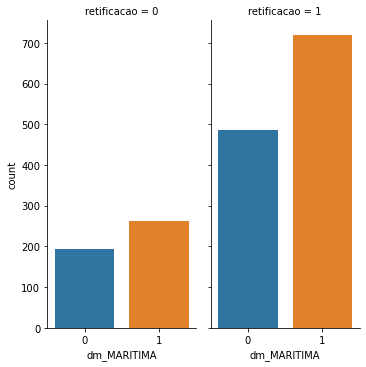

In [68]:
# Plotando a variável dm_MARITIMA
sns.catplot(data=df_catDI, x='dm_MARITIMA', col='retificacao', kind="count", height=5, aspect=0.5);

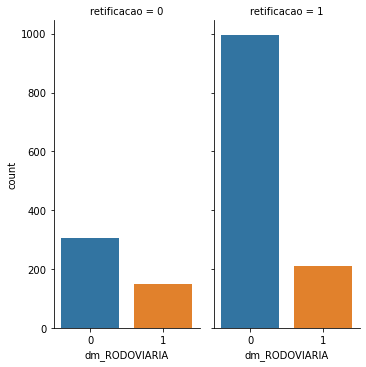

In [69]:
# Plotando a variável dm_RODOVIARIA
sns.catplot(data=df_catDI, x='dm_RODOVIARIA', col='retificacao', kind="count", height=5, aspect=0.5);

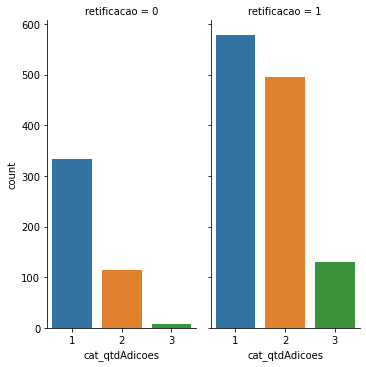

In [70]:
# Plotando a variável cat_qtdAdicoes do dataframe df_diSelecionadas
sns.catplot(data=df_diSelecionadas, x='cat_qtdAdicoes', col='retificacao', kind="count", height=5, aspect=0.5);

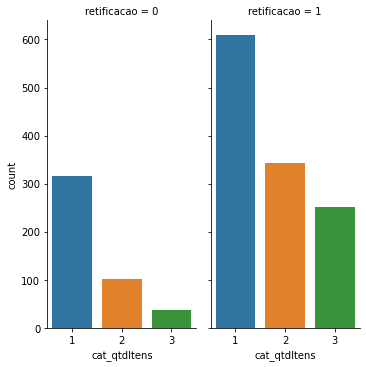

In [71]:
# Plotando a variável cat_qtdItens do dataframe df_diSelecionadas
sns.catplot(data=df_diSelecionadas, x='cat_qtdItens', col='retificacao', kind="count", height=5, aspect=0.5);

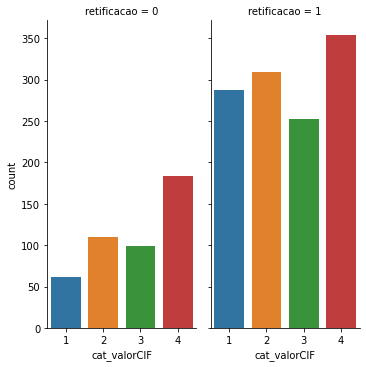

In [72]:
# Plotando a variável cat_valorCIF do dataframe df_diSelecionadas
sns.catplot(data=df_diSelecionadas, x='cat_valorCIF', col='retificacao', kind="count", height=5, aspect=0.5);

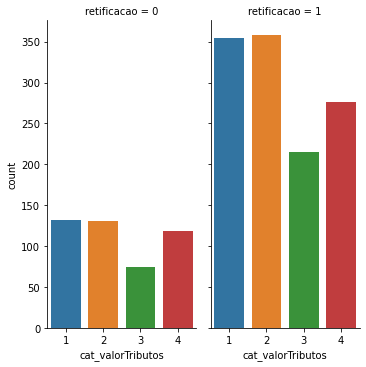

In [73]:
# Plotando a variável cat_valorTributos do dataframe df_diSelecionadas
sns.catplot(data=df_diSelecionadas, x='cat_valorTributos', col='retificacao', kind="count", height=5, aspect=0.5);

In [74]:
# Verificando se a variável retificacao (target) está balanceada
df_catDI['retificacao'].value_counts()/df_catDI.shape[0]

1    0.725738
0    0.274262
Name: retificacao, dtype: float64

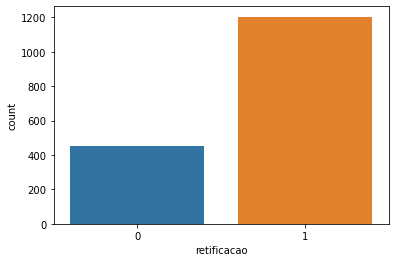

In [75]:
# Plotando o gráfico da variável retificacao (target)
sns.countplot(data=df_catDI, x='retificacao');

In [76]:
# Separando as variáveis em explicativas (predictor variables) e de resposta (target variables)
df_explicativas = df_catDI.drop(columns=['retificacao'])
df_explicativas.head()

,le_impPropria,dm_CONSUMO,dm_REGIMES_OUTROS,dm_ALEMANHA,dm_ARGENTINA,dm_CHINA,dm_EUA,dm_ITALIA,dm_PAIS_OUTROS,dm_AEREA,...,dm_qtdItens_2,dm_qtdItens_3,dm_valorCIF_1,dm_valorCIF_2,dm_valorCIF_3,dm_valorCIF_4,dm_valorTributos_1,dm_valorTributos_2,dm_valorTributos_3,dm_valorTributos_4
10,1,1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,0
35,1,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
72,1,1,0,0,0,0,0,1,0,1,...,0,0,1,0,0,0,1,0,0,0
81,1,1,0,0,0,0,0,0,1,1,...,1,0,1,0,0,0,1,0,0,0
95,1,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [77]:
df_resposta = df_catDI['retificacao']
df_resposta.head()

10    0
35    0
72    1
81    1
95    1
Name: retificacao, dtype: int64

In [78]:
# Selecionando as variáveis mais significativas do modelo

# Utilizando Regressão Logística

logreg = LogisticRegression(random_state = 0, max_iter = 150)
rfe = RFE(logreg) # n_features_to_select=10
rfe = rfe.fit(df_explicativas, df_resposta)
lrs = rfe.support_
print(rfe.support_)
print(rfe.ranking_)

[ True False False  True  True False False  True False  True False  True
  True  True  True False False  True  True False False  True False False
  True False]
[ 1  5  9  1  1 12  6  1 11  1 14  1  1  1  1  7  8  1  1 13  2  1  3  4
  1 10]


In [79]:
logit_model = sm.Logit(df_resposta, df_explicativas)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.528688
         Iterations 21
                           Logit Regression Results                           
Dep. Variable:            retificacao   No. Observations:                 1659
Model:                          Logit   Df Residuals:                     1639
Method:                           MLE   Df Model:                           19
Date:                Mon, 30 May 2022   Pseudo R-squ.:                  0.1000
Time:                        16:34:10   Log-Likelihood:                -877.09
converged:                       True   LL-Null:                       -974.58
Covariance Type:            nonrobust   LLR p-value:                 3.386e-31
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
le_impPropria          0.6347      0.339      1.870      0.061      -0.030       1.300
dm_C

In [80]:
# Utilizando o método RandomForestClassifier

emb_selector = SelectFromModel(RandomForestClassifier()) # random_state=42
emb_selector.fit(df_explicativas, df_resposta)
emb_support = emb_selector.get_support()
emb_feature = df_explicativas.loc[:,emb_support].columns.tolist()

In [81]:
# Utilizando o método XGBoost (Extreme Gradient Boosting)

X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(df_explicativas, df_resposta,
                                                                  test_size = 0.25, random_state = 0)

In [82]:
# Criando um classificador XGBoost
clf = XGBClassifier()

# Treinando o classificador XGBoost
clf.fit(X_treinamento, y_treinamento)

# Calculando o y_pred (predição do modelo) e avaliando a qualidade do ajuste
y_pred = clf.predict(X_teste)
predicao = [round(value) for value in y_pred]
acuracia = accuracy_score(y_teste, predicao)
print("Acurácia: {}".format(acuracia))

Acurácia: 0.7156626506024096


In [83]:
# Calcula a importância das features
importances = clf.feature_importances_
df_importances_XGB = pd.DataFrame({'feature': df_explicativas.columns,
                                   'importance': (importances * 100)})
df_importances_XGB

,feature,importance
0,le_impPropria,2.178599
1,dm_CONSUMO,3.729898
2,dm_REGIMES_OUTROS,0.000000
3,dm_ALEMANHA,3.539870
4,dm_ARGENTINA,2.749210
5,dm_CHINA,4.216241
6,dm_EUA,3.983007
7,dm_ITALIA,1.782276
8,dm_PAIS_OUTROS,3.589415
9,dm_AEREA,8.029812


In [84]:
# Verificando a distribuição da variável qtdItens
df_importances_XGB['importance'].describe()

count    26.000000
mean      3.846154
std       2.356398
min       0.000000
25%       3.072503
50%       3.563952
75%       3.914012
max      13.408695
Name: importance, dtype: float64

In [85]:
# Atribuindo valores lógicos iguais a "True" para as 50% melhores variáveis e "False" para as demais

def select_features(x):
    if x > 3.56:            # Ponto de corte utilizado para seleção das 50% melhores variáveis (mediana)
        x = 1
    else:
        x = 0
    return x

df_importances_XGB['select'] = df_importances_XGB['importance'].apply(lambda x: bool(select_features(x)))
df_importances_XGB['select'].unique()

array([False,  True])

In [86]:
df_importances_XGB

,feature,importance,select
0,le_impPropria,2.178599,False
1,dm_CONSUMO,3.729898,True
2,dm_REGIMES_OUTROS,0.000000,False
3,dm_ALEMANHA,3.539870,False
4,dm_ARGENTINA,2.749210,False
5,dm_CHINA,4.216241,True
6,dm_EUA,3.983007,True
7,dm_ITALIA,1.782276,False
8,dm_PAIS_OUTROS,3.589415,True
9,dm_AEREA,8.029812,True


In [87]:
# Selecionando as melhores variáveis (Feature Engineering)

# Foram eleitas as variáveis conforme tabela abaixo:

#                 feature  *  LRS    *  RFC    *  XGB   *  total
# **************************************************************
# (52) dm_valorTributos_4  *  True   *  True   *  True  *    3
# (39)    dm_qtdAdicoes_1  *  True   *  True   *  True  *    3
# (36)        dm_MARITIMA  *  True   *  True   *  True  *    3
# (35)           dm_AEREA  *  True   *  True   *  True  *    3
# (18)              dm_PE  *  True   *  False  *  True  *    2
# (51) dm_valorTributos_3  *  False  *  True   *  True  *    2
# (45)      dm_valorCIF_1  *  False  *  True   *  True  *    2
# (42)      dm_qtdItens_1  *  False  *  True   *  True  *    2
# (40)    dm_qtdAdicoes_2  *  False  *  True   *  True  *    2
# (37)      dm_RODOVIARIA  *  True   *  False  *  True  *    2

df_feature_selection = pd.DataFrame({'feature': df_explicativas.columns,
                                     'LRS': lrs,
                                     'RFC': emb_support,
                                     'XGB': df_importances_XGB['select']})
df_feature_selection['total'] = np.sum(df_feature_selection, axis = 1)
print(df_feature_selection.sort_values(['total'], ascending = False))

               feature    LRS    RFC    XGB  total
24  dm_valorTributos_3   True   True   True      3
9             dm_AEREA   True   True   True      3
11       dm_RODOVIARIA   True   True   True      3
12     dm_qtdAdicoes_1   True   True   True      3
13     dm_qtdAdicoes_2   True  False   True      2
23  dm_valorTributos_2  False   True   True      2
5             dm_CHINA  False   True   True      2
21       dm_valorCIF_4   True   True  False      2
20       dm_valorCIF_3  False   True   True      2
8       dm_PAIS_OUTROS  False   True   True      2
18       dm_valorCIF_1   True   True  False      2
15       dm_qtdItens_1  False   True   True      2
16       dm_qtdItens_2  False   True  False      1
22  dm_valorTributos_1  False   True  False      1
19       dm_valorCIF_2  False   True  False      1
17       dm_qtdItens_3   True  False  False      1
0        le_impPropria   True  False  False      1
14     dm_qtdAdicoes_3   True  False  False      1
1           dm_CONSUMO  False  

In [88]:
# Criando o dataframe com as variáveis selecionadas
df_explicativas_final = df_explicativas[['dm_valorTributos_3', 'dm_AEREA', 'dm_RODOVIARIA', 'dm_qtdAdicoes_1',
                                         'dm_qtdAdicoes_2', 'dm_qtdItens_1', 'dm_valorTributos_2', 'dm_CHINA',
                                         'dm_valorCIF_4', 'dm_valorCIF_3', 'dm_PAIS_OUTROS', 'dm_valorCIF_1']]
df_explicativas_final.head()

,dm_valorTributos_3,dm_AEREA,dm_RODOVIARIA,dm_qtdAdicoes_1,dm_qtdAdicoes_2,dm_qtdItens_1,dm_valorTributos_2,dm_CHINA,dm_valorCIF_4,dm_valorCIF_3,dm_PAIS_OUTROS,dm_valorCIF_1
10,0,1,0,1,0,1,0,0,0,0,1,1
35,0,0,1,1,0,1,0,0,0,0,1,1
72,0,1,0,0,1,1,0,0,0,0,0,1
81,0,1,0,0,1,0,0,0,0,0,1,1
95,0,0,0,1,0,1,0,1,0,0,0,1


In [89]:
# Separando os dados finais (após seleção de variáveis) para treino (80%) e teste (20%)
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(df_explicativas_final, df_resposta,
                                                                  test_size = 0.2, random_state = 0)

## Criando os modelos de Machine Learning

In [90]:
def mostra_confusion_matrix(cf,                   # dados da matriz de confusão
                            group_names = None,   # lista das labels mostradas em cada quadrado
                            categories = 'auto',  # lista das categorias mostradas nos eixos x e y
                            count = True,         # se True, mostra as quantidades em cada quadrado
                            percent = True,       # se True, mostra os percentuais em cada quadrado
                            cbar = True,          # se True, mostra uma barra de cores
                            xyticks = False,      # se True, mostra a marcação de x e y
                            xyplotlabels = False, # se True, mostra 'True Label' e 'Predicted Label'
                            figsize = (4, 4),     
                            cmap = 'Blues'):
    
    # Gera o texto dentro de cada quadrado
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # Plota o mapa de calor
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')

### 1. Modelo de Regressão Logística

In [91]:
# Criando dicionário com os hiperparâmetros
LR_dict = {'C':np.logspace(-3,3,7),
           'penalty':['l2'],
           'random_state': [0]}

In [92]:
# Treinando com a Regressão Logística
LR = LogisticRegression(random_state = 0, max_iter = 150)
LR_grid = GridSearchCV(estimator = LR, param_grid = LR_dict, scoring = 'accuracy', cv = 10)
LR_grid.fit(X_treinamento, y_treinamento)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=150, random_state=0),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l2'], 'random_state': [0]},
             scoring='accuracy')

In [93]:
LR_grid.best_params_

{'C': 0.1, 'penalty': 'l2', 'random_state': 0}

In [94]:
LR_grid.best_score_

0.7279562542720437

In [95]:
# Medindo a acurária com os dados de teste
y_pred_LR = LR_grid.predict(X_teste)

In [96]:
print(classification_report(y_teste, y_pred_LR, target_names=['0','1']))
print("Acurácia de Previsão:", accuracy_score(y_teste, y_pred_LR))

              precision    recall  f1-score   support

           0       0.57      0.04      0.08        92
           1       0.73      0.99      0.84       240

    accuracy                           0.73       332
   macro avg       0.65      0.52      0.46       332
weighted avg       0.69      0.73      0.63       332

Acurácia de Previsão: 0.7259036144578314


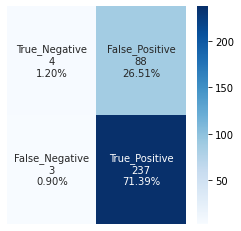

In [97]:
# Gerando a matriz de confusão (Regressão Logística)
cf_matrix = confusion_matrix(y_teste, y_pred_LR)
cf_labels = ['True_Negative', 'False_Positive', 'False_Negative', 'True_Positive']
cf_categories = ['Zero', 'One']
mostra_confusion_matrix(cf_matrix, group_names = cf_labels, categories = cf_categories)

### 2. Modelo Random Forest

In [98]:
# Criando dicionário com os hiperparâmetros
RF_dict = {'n_estimators':[50,100,200,300,800,1000],   # numero de estimadores que será testado
           'criterion':['gini', 'entropy'],            # critérios
           'bootstrap':[False, True],                  # amostragem com e sem reposição
           'random_state': [0]}
RF_dict

{'n_estimators': [50, 100, 200, 300, 800, 1000],
 'criterion': ['gini', 'entropy'],
 'bootstrap': [False, True],
 'random_state': [0]}

In [99]:
RF = RandomForestClassifier(random_state = 0)
RF_grid = GridSearchCV(estimator=RF,                # modelo Random Forest
                       param_grid=RF_dict,          # dicionario com parametros
                       scoring='accuracy',          # parametro de validação: acurácia
                       cv=10)                       # cross-validation = 10 folds
RF_grid

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0),
             param_grid={'bootstrap': [False, True],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [50, 100, 200, 300, 800, 1000],
                         'random_state': [0]},
             scoring='accuracy')

In [100]:
RF_grid.fit(X_treinamento, y_treinamento)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0),
             param_grid={'bootstrap': [False, True],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [50, 100, 200, 300, 800, 1000],
                         'random_state': [0]},
             scoring='accuracy')

In [101]:
# Medindo a acurária com os dados de teste
y_pred_RF = RF_grid.predict(X_teste)

In [102]:
print(classification_report(y_teste, y_pred_RF, target_names=['0','1']))
print("Acurácia de Previsão:", accuracy_score(y_teste, y_pred_RF))

              precision    recall  f1-score   support

           0       0.52      0.30      0.38        92
           1       0.77      0.89      0.83       240

    accuracy                           0.73       332
   macro avg       0.64      0.60      0.60       332
weighted avg       0.70      0.73      0.70       332

Acurácia de Previsão: 0.7289156626506024


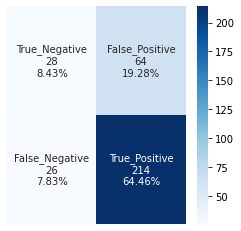

In [103]:
# Gerando a matriz de confusão (Random Forest)
cf_matrix = confusion_matrix(y_teste, y_pred_RF)
cf_labels = ['True_Negative', 'False_Positive', 'False_Negative', 'True_Positive']
cf_categories = ['Zero', 'One']
mostra_confusion_matrix(cf_matrix, group_names = cf_labels, categories = cf_categories)

### 3. Modelo XGBoost (Extreme Gradient Boosting)

In [104]:
ml_XGB = XGBClassifier(scale_pos_weight=1,
                       learning_rate=0.01,  
                       colsample_bytree = 1,
                       subsample = 0.8,
                       objective='binary:logistic',
                       eval_metric='logloss',
                       n_estimators=1000, 
                       reg_alpha = 0.3,
                       max_depth= 3, 
                       gamma=1, 
                       max_delta_step=5)
ml_XGB.fit(X_treinamento, y_treinamento)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=5, max_depth=3, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.3, reg_lambda=1, ...)

In [105]:
# Cross-Validation com 10 folds
a_scores_CV = cross_val_score(ml_XGB, X_treinamento, y_treinamento, cv = 10)
print(f'Média das Acurácias calculadas pelo CV....: {100*round(a_scores_CV.mean(),4)}')
print(f'std médio das Acurácias calculadas pelo CV: {100*round(a_scores_CV.std(),4)}')
print(f'Acurácias: {a_scores_CV}')

Média das Acurácias calculadas pelo CV....: 72.8
std médio das Acurácias calculadas pelo CV: 1.63
Acurácias: [0.72180451 0.69172932 0.7443609  0.73684211 0.7518797  0.72932331
 0.72180451 0.74242424 0.71969697 0.71969697]


In [106]:
# Medindo a acurária com os dados de teste
# Rodando o algoritmo XGBoost com a base de Teste
y_pred_XGB = ml_XGB.predict(X_teste)
print(classification_report(y_teste, y_pred_XGB, target_names=['0','1']))
print("Acurácia de Previsão:", accuracy_score(y_teste, y_pred_XGB))

              precision    recall  f1-score   support

           0       0.50      0.16      0.25        92
           1       0.75      0.94      0.83       240

    accuracy                           0.72       332
   macro avg       0.62      0.55      0.54       332
weighted avg       0.68      0.72      0.67       332

Acurácia de Previsão: 0.7228915662650602


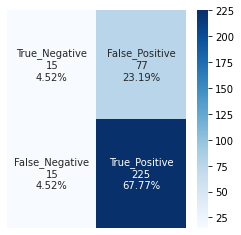

In [107]:
# Gerando a matriz de confusão (XGBoost)
cf_matrix = confusion_matrix(y_teste, y_pred_XGB)
cf_labels = ['True_Negative', 'False_Positive', 'False_Negative', 'True_Positive']
cf_categories = ['Zero', 'One']
mostra_confusion_matrix(cf_matrix, group_names = cf_labels, categories = cf_categories)